### Ensemble Kalman Filter Tutorial - CIDER 2019

**Yan Zhan & Patricia M Gregg**

Please cite these papers if you want to use this code to publish:

*Zhan, Y., & Gregg, P. M. (2017). Data assimilation strategies for volcano geodesy. Journal of Volcanology and Geothermal Research, 344(Supplement C), 13–25. https://doi.org/10.1016/j.jvolgeores.2017.02.015*

&

*Gregg, P. M., and J. C. Pettijohn (2016), A multi-data stream assimilation framework for the assessment of volcanic unrest, Journal of Volcanology and Geothermal Research, 309, 63-77, https://doi.org/10.1016/j.jvolgeores.2015.11.008.*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy

### Ensemble Kalman Filter analysis

Original EnKF equations and code can be found at:

*Evensen, G. (2003). The Ensemble Kalman Filter: theoretical formulation and practical implementation. Ocean Dynamics, 53(4), 343–367. https://doi.org/10.1007/s10236-003-0036-9*

Also see: https://enkf.nersc.no, for more information.

#### The updated Ensemble Matrix can be expressed by 


$A^a = A + P_e H^T(H P_e H^T + R_e)^{-1} (D - H A)$

$A$: matrix holding the ensemble members

$P_e$: ensemble covariance matrix

$R_e$: measurement error covariance matrix

$H$: measurement operator relating the true model state

<img src="./fig/EnKF_method.png" width="600">


In [30]:
# EnKF is the ensemble Kalman Filter analysis processor with one core
# the algorithm is after Everson (2003)   
# A_EnKF = EnKF(A_EnKF = 2d array, data = 1d array, dataerr = 1d array)
# Input: A_EnKF, data, dataerr
#		"A_EnKF" = [[P1_1, P1_2, ..., P1_N],
#					[P2_1, P2_2, ..., P2_N],
#					...
#					[Pnp_1, Pnp_2, ..., Pnp_N],
#					[F1_1, F1_2, ..., F1_N],
#					[F2_1, F2_2, ..., F2_N],
#					...
#					[Fm_1, Fm_2, ..., Fm_N]]
#		in which: np = number of the parameters
#				  N  = number of ensembles
#				  m  = number of measurements
#		"data" = [d1, d2, ..., dm]
#		"dataerr" = [e1, e2, ..., em]
#
# Output: "A_EnKF"
def EnKF(A_EnKF, data, dataerr):
    # A matrix
    A = copy.deepcopy(A_EnKF)
    # Number of the measurement
    M = len(data)
    # Number of the ensemble
    N = A_EnKF.shape[1]
    # Number of the measurements + parameters
    Ndim = A_EnKF.shape[0]
    # Number of the parameters
    Np = Ndim - M

    # 1_N matrix
    OneN = np.ones([N, N]) / N

    # A bar matrix: A_bar = A OneN
    A_bar = A @ OneN
    # A' = A - A_bar
    A_prm = A - A_bar

    # H matrix
    H1 = np.zeros([Np, M])
    H2 = np.identity(M)
    H = np.vstack((H1, H2)).transpose()

    # Measurement Matrix
    d = np.kron(np.ones((N, 1)), data).transpose()

    # E-matrix: method I (using uncertainty)
    E = np.kron(np.ones((N, 1)), dataerr).transpose()

    # measurement + pertubation
    D = d + E

    # DHA = D - HA
    DHA = D - H @ A

    # HApE = HA' + E
    HApE = H @ A_prm + E

    # Singular value decomposition
    U, S, V = np.linalg.svd(HApE)
    SIGinv = (S @ S.T) ** (-1)
    
    # calculate the analysis ensemble
    X1 = SIGinv * U.transpose()
    X2 = X1 @ DHA
    X3 = U @ X2
    X4 = (H @ A_prm).transpose() @ X3
    Aa = A + A_prm @ X4

    return Aa

#### Mogi (1958) analytical model

**Surface displacements can be expressed by:**

$$U_x = \frac{B (x-x_0)}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$U_y = \frac{B (y-y_0)}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$U_z = \frac{B d}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$B = a^3 dP \frac{(1 - \nu)}{\mu}$$

$$R = \sqrt{(x-x_0)^2 + (y-y_0)^2}$$

$(x_0, y_0)$: center of the chamber

$d$: depth of the chamber center

$a$: chamber radius

$dP$: overpressure along the chamber wall

$\mu$: shear modulus


In [93]:
# Mogi (1958) Model
def mogi_disp(x, y, x0=0, y0=0, d=5e3, a=5e2, dP=100e6, E=30e9, nu=0.25):
    # Input
    # x: 1d array
    # y: 1d array (y = np.zeros(x.shape) if in axial-symmertic 2D model)
    # magma chamber location (x0, y0) [m]
    # magma chamber depth: d (downward posititve) [m]
    # magma chamber radius: a (always positive) [m]
    # overpressure: dP (expanding as positive) [Pa]
    # Young's Modulus: E [Pa]
    # Poisson's ration: nu [1]
    # Output
    # displacement in x, y, z direction = (du, dv, dw)

    # shear modulus
    mu = E / 2 / (1 + nu)
    # distance to the center (x0, y0)
    R = ((x - x0) ** 2 + (y - y0) ** 2) ** (1 / 2)
    # load term
    A = (1 - nu) * (a ** 3) * dP / mu
    # displacement
    du = A * (x - x0) / ((d ** 2 + R ** 2) ** (3 / 2))
    dv = A * (y - y0) / ((d ** 2 + R ** 2) ** (3 / 2))
    dw = A * d / ((d ** 2 + R ** 2) ** (3 / 2))
    return du, dv, dw

In [94]:
# McTigue (1988) model
def mctigue_disp(x, y, x0=0, y0=0, d=5e3, a=5e2, dP=100e6, E=30e9, nu=0.25):
    # Input
    # x: 1d array
    # y: 1d array (y = np.zeros(x.shape) if in axial-symmertic 2D model)
    # magma chamber location (x0, y0) [m]
    # magma chamber depth: d (downward posititve) [m]
    # magma chamber radius: a (always positive) [m]
    # overpressure: dP (expanding as positive) [Pa]
    # Young's Modulus: E [Pa]
    # Poisson's ration: nu [1]
    # Output
    # displacement in x, y, z direction = (du, dv, dw)
    
    # shear modulus
    mu = E / 2 / (1 + nu)
    # dimensionless excess pressure (pressure/shear modulus)
    P_G = dP / mu
    # coordinates system centered in (x0,y0)
    xxn = x - x0
    yyn = y - y0
    # radial distance from source center
    r = (xxn ** 2 + yyn ** 2) ** (1/2)
    # dimensionless coordinates
    csi = xxn / d
    psi = yyn / d
    rho = r / d
    e = a / d
    # constant and expression used in the formulas 
    f1 = 1 / ((rho ** 2 + 1) ** 1.5)
    f2 = 1 / ((rho ** 2 + 1) ** 2.5)
    c1 = e ** 3 / (7 - 5 * nu)
    # displacement (dimensionless) [McTigue (1988), eq. (52) and (53)] 
    uzbar = e ** 3 * (1 - nu) * f1 * (1 - c1 * (0.5 * (1 + nu) - 3.75 * (2 - nu)/(rho ** 2 + 1)))
    urbar = rho * uzbar

    # displacement (dimensional) 
    u = urbar * P_G * d * xxn / (r + 1e-6)
    v = urbar * P_G * d * yyn / (r + 1e-6)
    w = uzbar * P_G * d
    return u, v, w

### Generate synthetic data
#### A surfance displacement field with high-spatial resolution (InSAR like)
#### A surfance displacement field with high-temporal resolution (GNSS like)

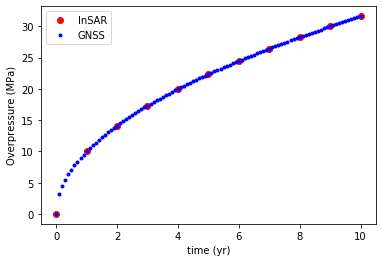

In [112]:
# time series
ti = np.linspace(0,10,11)
tg = np.linspace(0,10,101)

# Mogi source for synthetic deformation
# (x, y, z) for the point source (km)
xs = 0
ys = 0
zs = -3
# radius (km)
rs = 2
# overpressure trajectory (MPa) InSAR
OPi = ti ** (1/2) * 10
# overpressure trajectory (MPa) GNSS
OPg = tg ** (1/2) * 10

# material properties
E = 30e9
nu = 0.25

# plot the overpressure trajectory
plt.plot(ti, OPi, 'ro', label='InSAR')
plt.plot(tg, OPg, 'b.', label='GNSS')
plt.xlabel('time (yr)')
plt.ylabel('Overpressure (MPa)')
plt.legend()
plt.show()

# X, Y grid
X_InSAR, Y_InSAR = np.meshgrid(np.linspace(-5e3,5e3,51), np.linspace(-5e3,5e3,51))
# number of measurements
nobs = len(X_InSAR.reshape(-1))

#### Create the synthetic LOS displacement (InSAR)

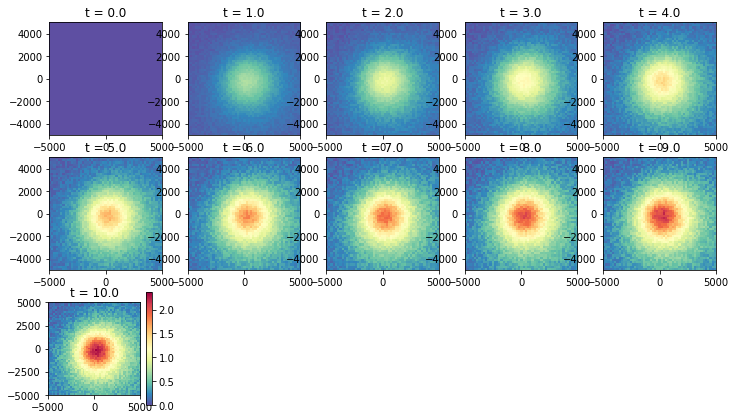

In [209]:
# allocate the measurements
LOS_disp = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])
Uncen = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])

# define the looking angle
theta = 45 * np.pi / 180
phi = 23 * np.pi / 180
lkag = [np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)]

# calcualte the displacement
for i in np.arange(0, len(ti)):
    Um, Vm, Wm = mctigue_disp(X_InSAR, Y_InSAR,
                           x0=xs*1e3, y0=ys*1e3,
                           d=-zs*1e3, a=rs*1e3, 
                           dP=OPi[i]*1e6, E=E, nu=nu
                          )
    
    disp = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]
    random_error = np.random.rand(X_InSAR.shape[0], X_InSAR.shape[1]) * disp.max() * 0.1
    Uncen[:, :, i] = random_error
    LOS_disp[:, :, i] = disp + random_error
    cmax = LOS_disp[:, :, i].max()

## reformat the dataset for EnKF
# convert measurement location to 1d array
x_InSAR = X_InSAR.reshape(-1)
y_InSAR = Y_InSAR.reshape(-1)
# convert measurement and error to 1d array
dat_InSAR = np.zeros([nobs, len(t)])
err_InSAR = np.zeros([nobs, len(t)])
# reformat
for i in np.arange(0, len(t)):
    dat_InSAR[:, i] = LOS_disp[:,:,i].reshape(-1)
    err_InSAR[:, i] = Uncen[:,:,i].reshape(-1)
    
# plot synthetic InSAR data
plt.figure(2, figsize=(12,12))
for i in np.arange(0, len(t)):
    plt.subplot(5,5,i+1)
    plt.imshow(LOS_disp[:,:,i],
              extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
              vmin=0, vmax=cmax,
              cmap=cm.Spectral_r)
    plt.title('t = {}'.format(ti[i]))
plt.colorbar()
plt.show()

#### Create synthetic GNSS data

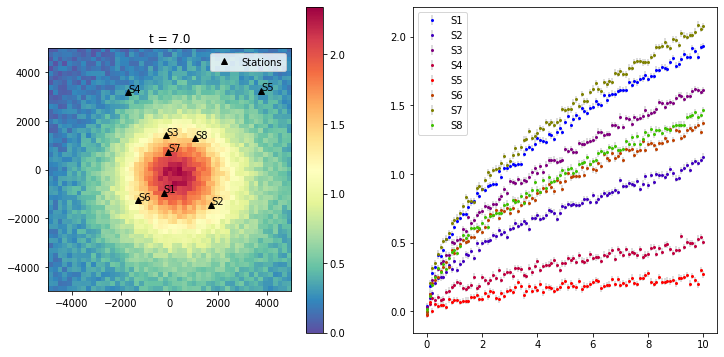

In [153]:
# number of stations
NStation = 8
# generate random location of GNSS stations
x_GNSS = np.random.standard_normal(NStation) * 2e3
y_GNSS = np.random.standard_normal(NStation) * 2e3

# plot location of the GNSS stations
plt.figure(6, figsize=(12,6))
plt.subplot(121)
plt.plot(x_GNSS, y_GNSS, 'k^', label='Stations')
for i in np.arange(0, NStation):
    plt.text(x_GNSS[i], y_GNSS[i], "S{}".format(i+1))
plt.imshow(LOS_disp[:,:,-1],
           extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
           vmin=0, vmax=cmax,
           cmap=cm.Spectral_r)
plt.title('t = {}'.format(ti[i]))
plt.colorbar()
plt.legend()

# allocate the measurements
Gx = np.zeros([NStation, len(tg)])
Gy = np.zeros([NStation, len(tg)])
Gz = np.zeros([NStation, len(tg)])
# uncertainty of GNSS
sx0 = cmax * 1e-3 * 5
sy0 = sx0
sz0 = sx0 * 2
# Error data of GNSS
Sx = np.ones([NStation, len(tg)]) * sx0
Sy = np.ones([NStation, len(tg)]) * sy0
Sz = np.ones([NStation, len(tg)]) * sz0

# calcualte the displacement
for i in np.arange(0, len(tg)):
    Um, Vm, Wm = mctigue_disp(x_GNSS, y_GNSS,
                           x0=xs*1e3, y0=ys*1e3,
                           d=-zs*1e3, a=rs*1e3, 
                           dP=OPg[i]*1e6, E=E, nu=nu
                          )
    Gx[:, i] = Um + np.random.standard_normal(NStation) * sx0
    Gy[:, i] = Vm + np.random.standard_normal(NStation) * sy0
    Gz[:, i] = Wm + np.random.standard_normal(NStation) * sz0
    
plt.subplot(122)
cmap = cm.get_cmap('brg')
for i in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[i, :],
                 yerr=Sz[i, :],
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(i/NStation),
                 markeredgecolor=cmap(i/NStation),
                 label='S{}'.format(i+1)
                )
plt.legend()    
plt.show()
    

### Combine InSAR and GNSS data

In [217]:
# uniform timeseries
tu = np.sort(np.unique(np.hstack([ti, tg])))

# allocate data dict
DATA = {"x": [],
        "y": [],
        "typ": [],
        "ddvx": [],
        "ddvy": [],
        "ddvz": [],
        "dat": [],
        "err": []
       }

# do for all time steps
for i in np.arange(0, len(tu)):
    LOCx = []
    LOCy = []
    Type = []
    DDVx = []
    DDVy = []
    DDVz = []
    data = []
    erro = []
    
    # if there is InSAR data
    if tu[i] in ti:
        # append location
        LOCx = np.hstack([LOCx, x_InSAR])
        LOCy = np.hstack([LOCy, y_InSAR])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(x_InSAR.shape)])
        # looking angle
        DDVx = np.hstack([DDVx, np.ones(x_InSAR.shape) * lkag[0]])
        DDVy = np.hstack([DDVy, np.ones(x_InSAR.shape) * lkag[1]])
        DDVz = np.hstack([DDVz, np.ones(x_InSAR.shape) * lkag[2]])
        # find InSAR data and error
        ii = np.where(ti == tu[i])[0][0]
        data = np.hstack([data, dat_InSAR[:, ii]])
        erro = np.hstack([erro, err_InSAR[:, ii]])
        
    # if there is GNSS data
    if tu[i] in tg:
        # append location
        LOCx = np.hstack([LOCx, x_GNSS, x_GNSS, x_GNSS])
        LOCy = np.hstack([LOCy, y_GNSS, y_GNSS, y_GNSS])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(len(x_GNSS) * 3) + 1])
        # looking angle (E=[1,0,0], N=[0,1,0], U=[0,0,1])
        DDVx = np.hstack([DDVx, np.ones(len(x_GNSS)), np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVy = np.hstack([DDVy, np.zeros(len(x_GNSS)), np.ones(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVz = np.hstack([DDVz, np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS)), np.ones(len(x_GNSS))])
        # find GNSS data and error
        ig = np.where(tg == tu[i])[0][0]
        data = np.hstack([data, Gx[:, ig]])
        data = np.hstack([data, Gy[:, ig]])
        data = np.hstack([data, Gz[:, ig]])
        erro = np.hstack([erro, Sx[:, ig]])
        erro = np.hstack([erro, Sy[:, ig]])
        erro = np.hstack([erro, Sz[:, ig]])

    # storing data
    DATA["x"].append(LOCx)
    DATA["y"].append(LOCy)   
    DATA["typ"].append(Type)
    DATA["ddvx"].append(DDVx)
    DATA["ddvy"].append(DDVy)
    DATA["ddvz"].append(DDVz)
    DATA["dat"].append(data)
    DATA["err"].append(erro)
    
    # print status
    print("t={}, x={}, typ={}, ddv={}, dat={}, err={}".format(tu[i],
                                                             len(LOCx),
                                                             len(Type),
                                                             len(DDVx),
                                                             len(data),
                                                             len(erro)))

t=0.0, x=2625, typ=2625, ddv=2625, dat=2625, err=2625
t=0.1, x=24, typ=24, ddv=24, dat=24, err=24
t=0.2, x=24, typ=24, ddv=24, dat=24, err=24
t=0.30000000000000004, x=24, typ=24, ddv=24, dat=24, err=24
t=0.4, x=24, typ=24, ddv=24, dat=24, err=24
t=0.5, x=24, typ=24, ddv=24, dat=24, err=24
t=0.6000000000000001, x=24, typ=24, ddv=24, dat=24, err=24
t=0.7000000000000001, x=24, typ=24, ddv=24, dat=24, err=24
t=0.8, x=24, typ=24, ddv=24, dat=24, err=24
t=0.9, x=24, typ=24, ddv=24, dat=24, err=24
t=1.0, x=2625, typ=2625, ddv=2625, dat=2625, err=2625
t=1.1, x=24, typ=24, ddv=24, dat=24, err=24
t=1.2000000000000002, x=24, typ=24, ddv=24, dat=24, err=24
t=1.3, x=24, typ=24, ddv=24, dat=24, err=24
t=1.4000000000000001, x=24, typ=24, ddv=24, dat=24, err=24
t=1.5, x=24, typ=24, ddv=24, dat=24, err=24
t=1.6, x=24, typ=24, ddv=24, dat=24, err=24
t=1.7000000000000002, x=24, typ=24, ddv=24, dat=24, err=24
t=1.8, x=24, typ=24, ddv=24, dat=24, err=24
t=1.9000000000000001, x=24, typ=24, ddv=24, dat=24, e

#### Define the number of ensemble and number of iterations

In [228]:
# number of ensemble
nens = 300
# number of iteration
nitr = 5

#### Initial ensemble

The initial ensemble is base on your gauss of the model parameters. It does not affect the final result, if you have enough iterations.


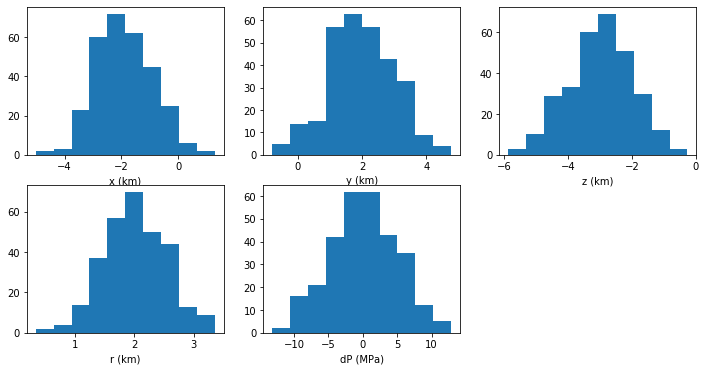

In [229]:
# number of the parameters
npar = 5
# Initial parameter guess
# point source location
# x (km)
xc0 = np.random.standard_normal(nens) * 1 + -2
# y (km)
yc0 = np.random.standard_normal(nens) * 1 + 2
# z (km)
zc0 = np.random.standard_normal(nens) * 1 - 3
# radius (km)
rc0 = np.random.standard_normal(nens) * 0.5 + 2
# overpressure (MPa)
dp0 = np.random.standard_normal(nens) * 5 + 0

## Plot initial ensemble parameter
plt.figure(3,figsize=(12,6))
plt.subplot(231)
plt.hist(xc0)
plt.xlabel('x (km)')
plt.subplot(232)
plt.hist(yc0)
plt.xlabel('y (km)')
plt.subplot(233)
plt.hist(zc0)
plt.xlabel('z (km)')
plt.subplot(234)
plt.hist(rc0)
plt.xlabel('r (km)')
plt.subplot(235)
plt.hist(dp0)
plt.xlabel('dP (MPa)')
plt.show()

### Start data assimilation

**Step 1.** Load data and uncertainty (i.e. synthetic InSAR like data)

**Step 2.** Calculate forecast ensemble (i.e. Mogi model)

**Step 3.** EnKF analysis (i.e. *Aa = A + K(D - HA)*)

**Step 4.** Update parameter for the model (i.e. Mogi model parameter)

**Step 5.** Go to **Step 2** within iterations; Go to **Step 1** if iterations end; **End** if no new data. 

## (1) Use InSAR data only

In [231]:
# number of measurements
nobs = len(X_InSAR.reshape(-1))
# allocate the A matrix
A = np.zeros([npar + nobs, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = rc0
A[4, :] = dp0

# allocate the root mean square error
RMSE = np.zeros([len(ti), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(ti)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]

# for all time steps
for step in np.arange(1, len(ti)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = dat_InSAR[:, step]
    Err = err_InSAR[:, step]
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            Um, Vm, Wm = mctigue_disp(x_InSAR, y_InSAR,
                                   x0=A[0, i]*1e3, y0=A[1, i]*1e3,
                                   d=-A[2, i]*1e3, a=A[3, i]*1e3, 
                                   dP=A[4, i]*1e6, E=E, nu=nu
                                  )
            # calculate the LOS displacement
            LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]
            # store the data into A matrix
            A[npar:npar+nobs, i] = LOS_model
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((LOS_model - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    
print('All done')

step = 1
RMSE = 0.7236891981971805
RMSE = 0.4042328404865069
RMSE = 0.3019458450279313
RMSE = 0.2621874756450597
RMSE = 0.23200766131005907
step = 2
RMSE = 0.34685095905932983
RMSE = 0.3023254710292856
RMSE = 8.825897263745798
RMSE = 0.27085648126446793
RMSE = 0.2381558753428294
step = 3
RMSE = 0.2611130384254553
RMSE = 0.21854250434597897
RMSE = 0.1840064829277237
RMSE = 0.15603795544812468
RMSE = 0.13369105044006033
step = 4
RMSE = 0.15685387332835132
RMSE = 0.13735066122489437
RMSE = 0.12194490955680079
RMSE = 0.10978754096995208
RMSE = 0.1001933241880797
step = 5
RMSE = 0.1315195791051988
RMSE = 0.12176040198103716
RMSE = 0.11336967945720891
RMSE = 0.10616490581566405
RMSE = 0.09998909900805793
step = 6
RMSE = 0.13607422654880386
RMSE = 0.12888493729033848
RMSE = 0.12233016123350711
RMSE = 0.11637314259163394
RMSE = 0.11097747994644143
step = 7
RMSE = 0.14645064316216386
RMSE = 0.14018842956054978
RMSE = 0.13430442201218867
RMSE = 0.12879437187868475
RMSE = 0.12365173158231789
step

### Compare model results to InSAR data (InSAR only)

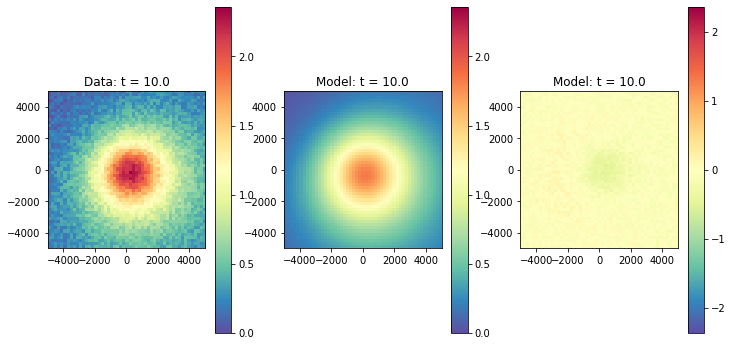

In [232]:
# select step
step = -1

# calculate the last step of the model
Um, Vm, Wm = mctigue_disp(X_InSAR, Y_InSAR,
                       x0=np.mean(param_est[0, :, step])*1e3, y0=np.mean(param_est[1, :, step])*1e3,
                       d=-np.mean(param_est[2, :, step])*1e3, a=np.mean(param_est[3, :, step])*1e3, 
                       dP=np.mean(param_est[4, :, step])*1e6, E=E, nu=nu
                      )
# calculate the LOS displacement
LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]

# Plot data
plt.figure(6, figsize=(12,6))
plt.subplot(131)
plt.imshow(LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Data: t = {}'.format(t[step]))

# Plot model
plt.subplot(132)
plt.imshow(LOS_model,
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(t[step]))

# Plot misfit
plt.subplot(133)
plt.imshow(LOS_model - LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=-cmax, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(t[step]))
plt.show()

### Plot RMSE vs time (InSAR only)

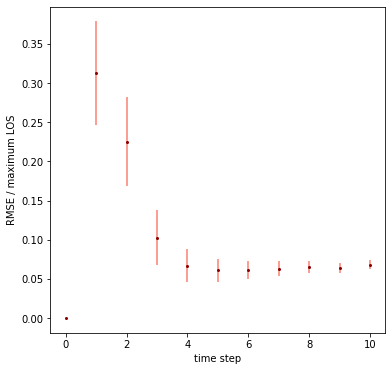

In [233]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=t, y=np.mean(RMSE[:, :], axis=1) / (np.max(dat, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(dat, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.show()

###  EnKF Estimation of source locations (InSAR only)

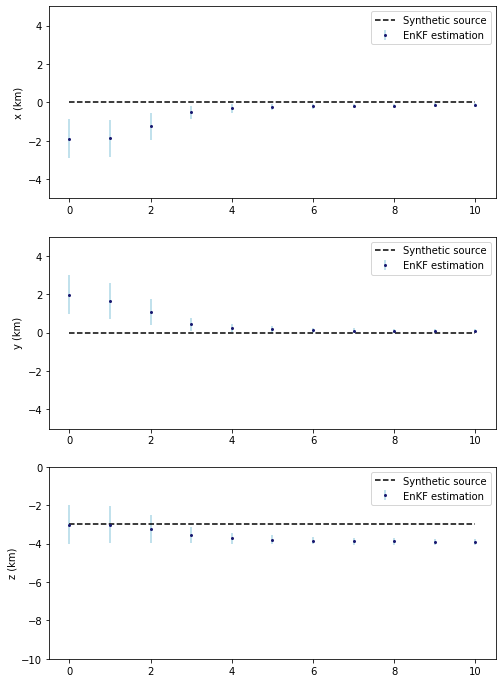

In [234]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                  np.ones(ti.shape) * rs,
                  OPi]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=ti, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
plt.show()


### Radius and Overpressure estimations (InSAR only)

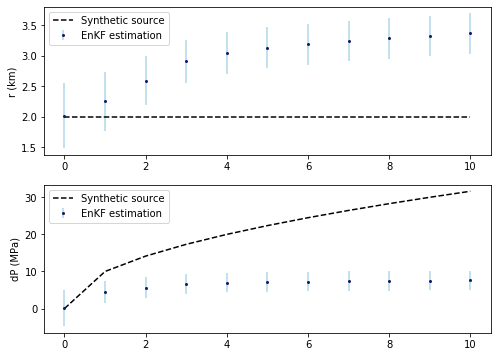

In [235]:
plt.figure(5, figsize=(8,6))
y_label = ['r (km)', 'dP (MPa)']
for par in np.arange(3, 5):
    # plot parameter estimation
    plt.subplot(2,1,par-2)
    plt.errorbar(x=ti, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
    
plt.show()

### Volume change (InSAR only)

#### Non-Unique issue

Mogi source is a point source, so that the radius and pressure cannot be determined uniquely.

**Mogi source:**

$$U_x = \frac{B (x-x_0)}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$...$$

$$B = a^3 dP \frac{(1 - \nu)}{\mu}$$

$$V = \frac{4 \pi a^3}{3}$$

$$a^3 = \frac{3 V}{4 \pi}$$

$$dP = \frac{\Delta V}{V} K $$

$$B = \frac{3 V}{4 \pi} \frac{\Delta V}{V} \frac{(1 - \nu)}{\mu} = C \Delta V$$

$$\Delta V = \frac{dP V}{K} = a^3 dP \frac{4 \pi}{3 K}$$

#### Volume change

Volume change as a combination of raidus and overpressure can be determined unqiuely.


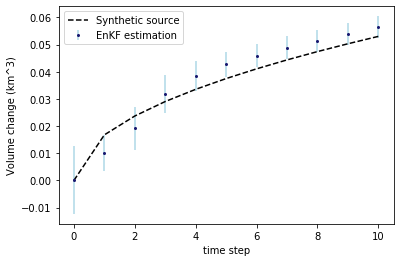

In [236]:
## calculate the volume change of models
am = param_est[3, :, :] * 1e3
dPm = param_est[4, :, :] * 1e6
K = E / 3 / (1 - 2 * nu)
dVm = am ** 3 * dPm * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = (rs*1e3) ** 3 * (OP*1e6) * 4 * np.pi / 3 / K

# plot
plt.plot(ti, dVs / 1e9, 'k--', label='Synthetic source')
plt.errorbar(x=t, y=np.mean(dVm, axis=0) / 1e9,
             yerr=np.std(dVm, axis=0) / 1e9,
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation'
            )
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.show()

## Use GNSS data only

In [251]:
nobs = NStation * 3
# allocate the A matrix
A = np.zeros([npar + nobs, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = rc0
A[4, :] = dp0

# allocate the root mean square error
RMSE = np.zeros([len(tg), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(tg)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]
GNSS_res_avg = np.zeros([len(tg), NStation * 3])
GNSS_res_std = np.zeros([len(tg), NStation * 3])

# for all time steps
for step in np.arange(1, len(tg)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = np.hstack([Gx[:, step], Gy[:, step], Gz[:, step]])
    Err = np.hstack([Sx[:, step], Sy[:, step], Sz[:, step]])
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            Um, Vm, Wm = mctigue_disp(x_GNSS, y_GNSS,
                                   x0=A[0, i]*1e3, y0=A[1, i]*1e3,
                                   d=-A[2, i]*1e3, a=A[3, i]*1e3, 
                                   dP=A[4, i]*1e6, E=E, nu=nu
                                  )
            
            # store the data into A matrix
            A[npar:npar+nobs, i] = np.hstack([Um, Vm, Wm])
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((np.hstack([Um, Vm, Wm]) - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    GNSS_res_avg[step, :] = np.mean(A[npar:npar+nobs, :], axis=1)
    GNSS_res_std[step, :] = np.std(A[npar:npar+nobs, :], axis=1)
    
print('All done')

step = 1
RMSE = 0.24842716957467645
RMSE = 0.17855304480549747
RMSE = 0.1530327095423587
RMSE = 0.1294770614290668
RMSE = 0.10987692009630076
step = 2
RMSE = 0.14295712446406134
RMSE = 0.12322831593071527
RMSE = 0.11839760675045781
RMSE = 0.17905509438344058
RMSE = 0.10544476574184931
step = 3
RMSE = 0.16261331871359458
RMSE = 0.10965123156269291
RMSE = 0.09067289487964011
RMSE = 0.07635285383986144
RMSE = 0.06548140926246947
step = 4
RMSE = 0.07505631433630527
RMSE = 0.06409479190850195
RMSE = 0.056064616560771344
RMSE = 0.05026673631477549
RMSE = 0.045473779568592186
step = 5
RMSE = 0.04904190357895593
RMSE = 0.04233200607004275
RMSE = 0.04174092148227211
RMSE = 0.03227163330279479
RMSE = 0.028988561814400793
step = 6
RMSE = 0.026939917349639176
RMSE = 0.023667946250718105
RMSE = 0.02162173053899169
RMSE = 0.020986156859267354
RMSE = 0.02099057868807645
step = 7
RMSE = 0.030774809763402668
RMSE = 0.02866940959368211
RMSE = 0.027972584135266036
RMSE = 0.029314290144115917
RMSE = 0.027

RMSE = 0.04937040422110735
RMSE = 0.048424377960207356
RMSE = 0.04754735780290985
RMSE = 0.04671673353678176
step = 58
RMSE = 0.04868713601332905
RMSE = 0.04787880742382571
RMSE = 0.047048541256848785
RMSE = 0.046219155829559135
RMSE = 0.045401613885391254
step = 59
RMSE = 0.0576944019227093
RMSE = 0.056672593544048494
RMSE = 0.055706920944924694
RMSE = 0.05477938066700969
RMSE = 0.05388190606273644
step = 60
RMSE = 0.055984233342148686
RMSE = 0.05513377005021037
RMSE = 0.05424852171089745
RMSE = 0.05335943018472747
RMSE = 0.052480550893363884
step = 61
RMSE = 0.05987328070200459
RMSE = 0.058994481287198
RMSE = 0.05810031995217583
RMSE = 0.05721136576416299
RMSE = 0.05633669895560336
step = 62
RMSE = 0.057411437757618936
RMSE = 0.056451188723492314
RMSE = 0.055506147489245664
RMSE = 0.054579917831041956
RMSE = 0.05367393208166741
step = 63
RMSE = 0.05676702963501567
RMSE = 0.055887608460432114
RMSE = 0.05505820258647514
RMSE = 0.054264282543688036
RMSE = 0.053498357405112766
step = 64


### RMSE (GNSS only)

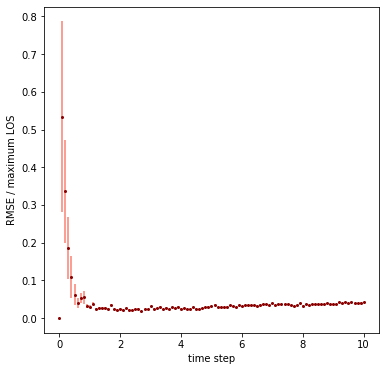

In [244]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=tg, y=np.mean(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.show()

### GNSS results (GNSS only)

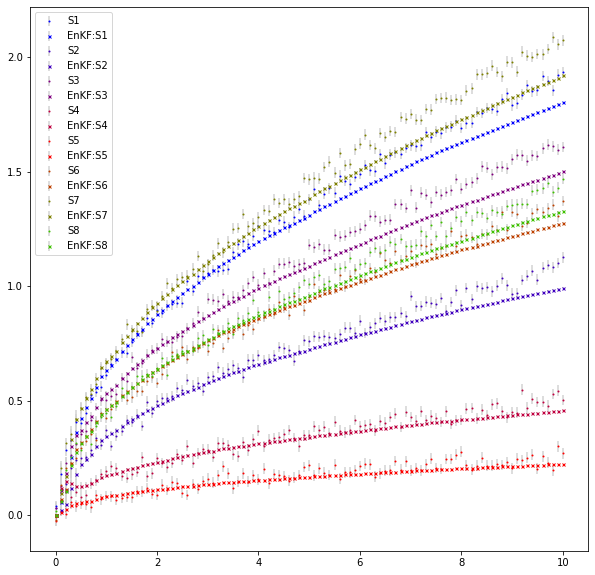

In [279]:
plt.figure(10, figsize=(10,10))
for istation in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[istation, :],
                 yerr=Sz[istation, :],
                 marker='o', markersize=1,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='S{}'.format(istation+1)
                )

    plt.errorbar(x=tg, 
                 y=GNSS_res_avg[:, istation + NStation * 2],
                 yerr=GNSS_res_std[:, istation + NStation * 2],
                 marker='x', markersize=3,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='EnKF:S{}'.format(istation+1)
                )

plt.legend()    
plt.show()
    

### Location of the chamber (GNSS only)

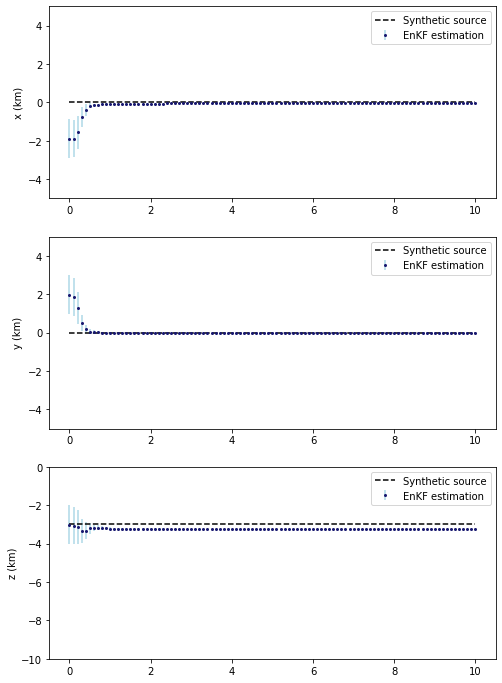

In [246]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                  np.ones(ti.shape) * rs,
                  OPi]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=tg, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
plt.show()



### Radius and overpressure (GNSS only)

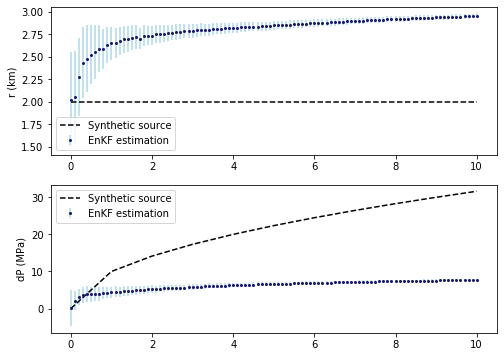

In [247]:
plt.figure(5, figsize=(8,6))
y_label = ['r (km)', 'dP (MPa)']
for par in np.arange(3, 5):
    # plot parameter estimation
    plt.subplot(2,1,par-2)
    plt.errorbar(x=tg, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
    
plt.show()

### Volume change (GNSS only)

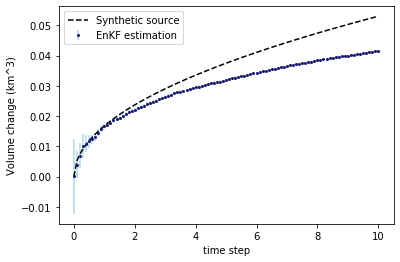

In [250]:
## calculate the volume change of models
am = param_est[3, :, :] * 1e3
dPm = param_est[4, :, :] * 1e6
K = E / 3 / (1 - 2 * nu)
dVm = am ** 3 * dPm * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = (rs*1e3) ** 3 * (OPg*1e6) * 4 * np.pi / 3 / K

# plot
plt.plot(tg, dVs / 1e9, 'k--', label='Synthetic source')
plt.errorbar(x=tg, y=np.mean(dVm, axis=0) / 1e9,
             yerr=np.std(dVm, axis=0) / 1e9,
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation'
            )
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.show()

## Use both InSAR and GNSS data

In [291]:
# allocate the A matrix
A = np.zeros([npar, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = rc0
A[4, :] = dp0

# allocate the root mean square error
RMSE = np.zeros([len(tu), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(tu)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]

GNSS_res_avg = np.zeros([len(tg), NStation * 3])
GNSS_res_std = np.zeros([len(tg), NStation * 3])

# for all time steps
for step in np.arange(1, len(tu)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = DATA['dat'][step]
    Err = DATA['err'][step]
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        # allocate A matrix result part
        A_res = np.zeros([len(Dat), nens])
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            Um, Vm, Wm = mctigue_disp(DATA['x'][step], DATA['y'][step],
                                   x0=A[0, i]*1e3, y0=A[1, i]*1e3,
                                   d=-A[2, i]*1e3, a=A[3, i]*1e3, 
                                   dP=A[4, i]*1e6, E=E, nu=nu
                                  )

            # store the data into A matrix
            A_res[:, i] = Um * DATA['ddvx'][step] + Vm * DATA['ddvy'][step] + Wm * DATA['ddvz'][step]
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((A_res[:, i] - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        A = np.vstack([A[0:npar], A_res])
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    if tu[step] in tg:
        ig = np.where(tg == tu[step])[0][0]
        GNSS_res_avg[ig, :] = np.mean(A_res[DATA['typ'][step]==2, :], axis=1)
        GNSS_res_std[ig, :] = np.std(A_res[DATA['typ'][step]==2, :], axis=1)

print('All done')

step = 1
RMSE = 0.24842716957467645
RMSE = 0.17855304480549747
RMSE = 0.1530327095423587
RMSE = 0.1294770614290668
RMSE = 0.10987692009630076
step = 2
RMSE = 0.14295712446406134
RMSE = 0.12322831593071527
RMSE = 0.11839760675045781
RMSE = 0.17905509438344058
RMSE = 0.10544476574184931
step = 3
RMSE = 0.16261331871359458
RMSE = 0.10965123156269291
RMSE = 0.09067289487964011
RMSE = 0.07635285383986144
RMSE = 0.06548140926246947
step = 4
RMSE = 0.07505631433630527
RMSE = 0.06409479190850195
RMSE = 0.056064616560771344
RMSE = 0.05026673631477549
RMSE = 0.045473779568592186
step = 5
RMSE = 0.04904190357895593
RMSE = 0.04233200607004275
RMSE = 0.04174092148227211
RMSE = 0.03227163330279479
RMSE = 0.028988561814400793
step = 6
RMSE = 0.026939917349639176
RMSE = 0.023667946250718105
RMSE = 0.02162173053899169
RMSE = 0.020986156859267354
RMSE = 0.02099057868807645
step = 7
RMSE = 0.030774809763402668
RMSE = 0.02866940959368211
RMSE = 0.027972584135266036
RMSE = 0.029314290144115917
RMSE = 0.027

RMSE = 0.04506919352852413
step = 58
RMSE = 0.04654903398361071
RMSE = 0.045706664912394855
RMSE = 0.04483862217855052
RMSE = 0.0439733022803568
RMSE = 0.04312370915022099
step = 59
RMSE = 0.05529671708732634
RMSE = 0.054224406835129295
RMSE = 0.05321577338562257
RMSE = 0.05225062350573638
RMSE = 0.05132025051365707
step = 60
RMSE = 0.11792717431655199
RMSE = 0.11784145497658306
RMSE = 0.11775629197739405
RMSE = 0.11767166693314395
RMSE = 0.11758756219105972
step = 61
RMSE = 0.06129240357549807
RMSE = 0.06044134939228537
RMSE = 0.05946525050175266
RMSE = 0.058457464393682816
RMSE = 0.057454357787983905
step = 62
RMSE = 0.05819244930170922
RMSE = 0.05709291578450665
RMSE = 0.05601129681150925
RMSE = 0.05495397087267917
RMSE = 0.05392311716547789
step = 63
RMSE = 0.05706810869023029
RMSE = 0.056074515044495656
RMSE = 0.05514451648720417
RMSE = 0.05425796740414049
RMSE = 0.053405395890874716
step = 64
RMSE = 0.060252072058878454
RMSE = 0.05947541455956182
RMSE = 0.058485166129072966
RMSE 

### RMSE (InSAR + GNSS)

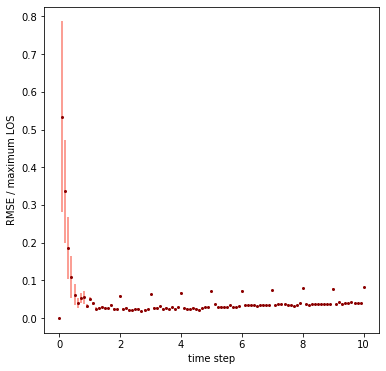

In [292]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=tu, y=np.mean(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.show()

### GNSS results (InSAR + GNSS)

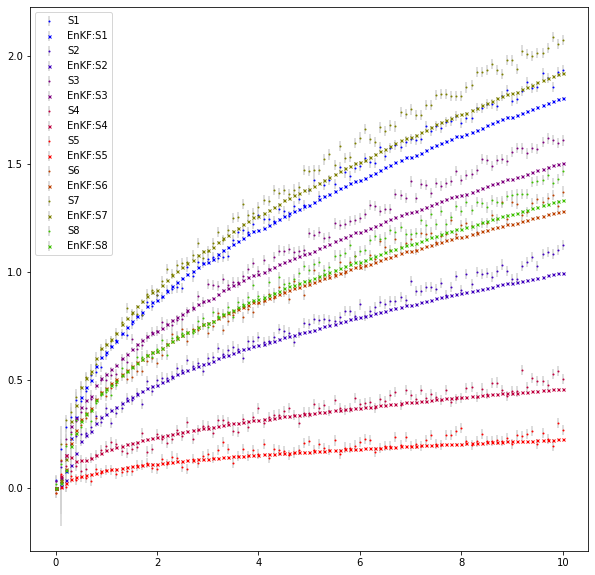

In [293]:
plt.figure(10, figsize=(10,10))
for istation in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[istation, :],
                 yerr=Sz[istation, :],
                 marker='o', markersize=1,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='S{}'.format(istation+1)
                )

    plt.errorbar(x=tg, 
                 y=GNSS_res_avg[:, istation + NStation * 2],
                 yerr=GNSS_res_std[:, istation + NStation * 2],
                 marker='x', markersize=3,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='EnKF:S{}'.format(istation+1)
                )

plt.legend()    
plt.show()

### InSAR results (InSAR + GNSS)

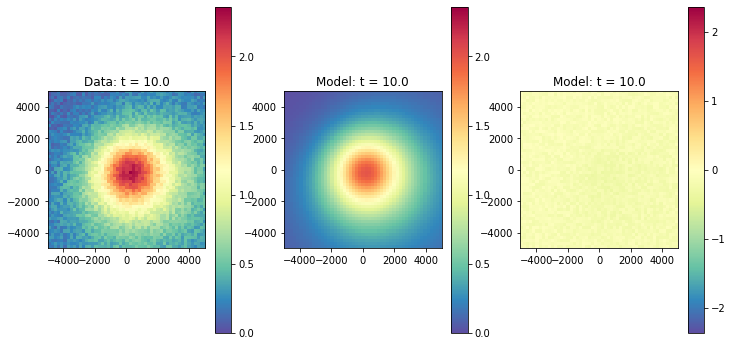

In [294]:
# select step
step = -1

# calculate the last step of the model
Um, Vm, Wm = mctigue_disp(X_InSAR, Y_InSAR,
                       x0=np.mean(param_est[0, :, step])*1e3, y0=np.mean(param_est[1, :, step])*1e3,
                       d=-np.mean(param_est[2, :, step])*1e3, a=np.mean(param_est[3, :, step])*1e3, 
                       dP=np.mean(param_est[4, :, step])*1e6, E=E, nu=nu
                      )
# calculate the LOS displacement
LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]

# Plot data
plt.figure(6, figsize=(12,6))
plt.subplot(131)
plt.imshow(LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Data: t = {}'.format(t[step]))

# Plot model
plt.subplot(132)
plt.imshow(LOS_model,
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(t[step]))

# Plot misfit
plt.subplot(133)
plt.imshow(LOS_model - LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=-cmax, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(t[step]))
plt.show()

### Location of the chamber (InSAR + GNSS)

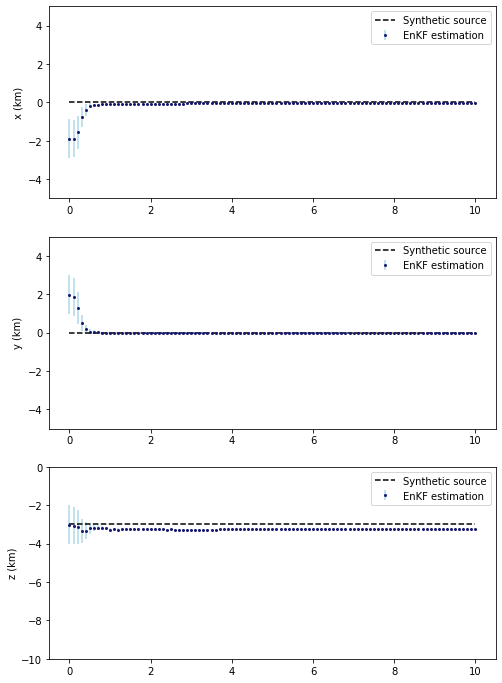

In [283]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                  np.ones(ti.shape) * rs,
                  OPi]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
plt.show()

### Radius and Overpressure (InSAR + GNSS)

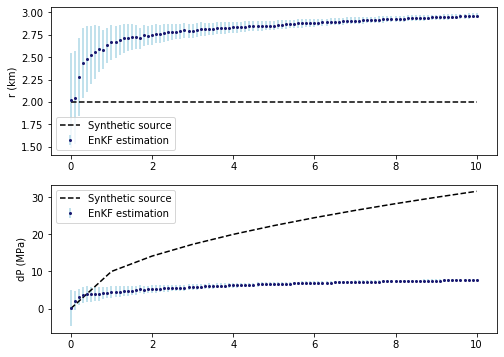

In [284]:
plt.figure(5, figsize=(8,6))
y_label = ['r (km)', 'dP (MPa)']
for par in np.arange(3, 5):
    # plot parameter estimation
    plt.subplot(2,1,par-2)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
    
plt.show()

### Volume change (InSAR + GNSS)

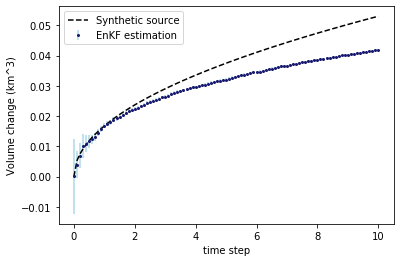

In [285]:
## calculate the volume change of models
am = param_est[3, :, :] * 1e3
dPm = param_est[4, :, :] * 1e6
K = E / 3 / (1 - 2 * nu)
dVm = am ** 3 * dPm * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = (rs*1e3) ** 3 * (OPg*1e6) * 4 * np.pi / 3 / K

# plot
plt.plot(tg, dVs / 1e9, 'k--', label='Synthetic source')
plt.errorbar(x=tu, y=np.mean(dVm, axis=0) / 1e9,
             yerr=np.std(dVm, axis=0) / 1e9,
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation'
            )
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.show()

# II) Ellipsoid model (Yang et al., 1988)

Modified after Battaglia et al. (2013)

Battaglia, M., Cervelli, P. F., & Murray, J. R. (2013). dMODELS: A MATLAB software package for modeling crustal deformation near active faults and volcanic centers. Journal of Volcanology and Geothermal Research, 254, 1–4. https://doi.org/10.1016/j.jvolgeores.2012.12.018


### Generate synthetic data

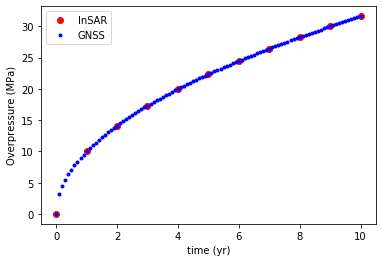

In [79]:
# time series
ti = np.linspace(0,10,11)
tg = np.linspace(0,10,101)

# Ellipsoid source for synthetic deformation
# (x, y, z) for the point source (km)
xs = 0
ys = 0
zs = -6
# Half height (km)
r1s = 1
# Half width (km)
r2s = 2

# dip angle
thetas = 50 / 180 * np.pi
# dip direction
phis = 60 / 180 * np.pi


# overpressure trajectory (MPa) InSAR
OPi = ti ** (1/2) * 10
# overpressure trajectory (MPa) GNSS
OPg = tg ** (1/2) * 10

# material properties
E = 30e9
nu = 0.25
# Shear Modulus
mu = E / 2 / (1 + nu)
# Lame's constant [Pa]
lamda = 2 * E * nu / (1 + nu) / (1 - 2 * nu)

# plot the overpressure trajectory
plt.plot(ti, OPi, 'ro', label='InSAR')
plt.plot(tg, OPg, 'b.', label='GNSS')
plt.xlabel('time (yr)')
plt.ylabel('Overpressure (MPa)')
plt.legend()
plt.show()

# X, Y grid
X_InSAR, Y_InSAR = np.meshgrid(np.linspace(-15e3,15e3,51), np.linspace(-15e3,15e3,51))
# number of measurements
nobs = len(X_InSAR.reshape(-1))

### Plot the shape of the ellipsoid

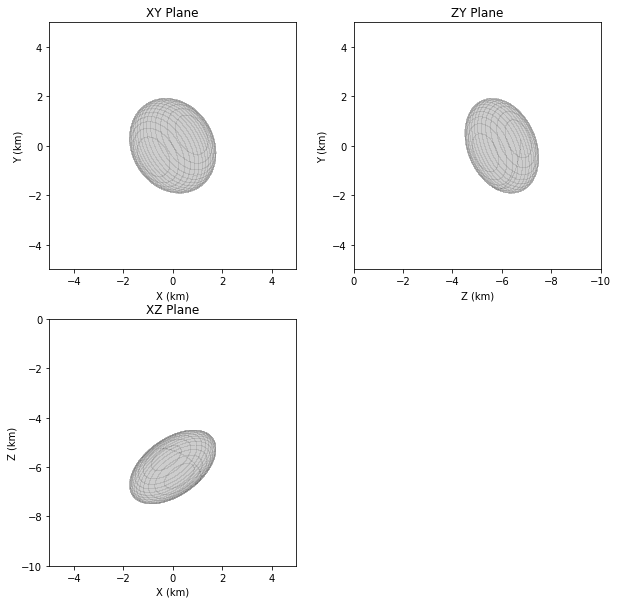

In [100]:
import vEnKF

plt.figure(5, figsize=(10,10))

ax_xy = plt.subplot(2,2,1)
ax_xz = plt.subplot(2,2,3)
ax_zy = plt.subplot(2,2,2)

ax_xy.set_xlim([-5, 5])
ax_xy.set_ylim([-5, 5])

ax_xz.set_xlim([-5, 5])
ax_xz.set_ylim([-10, 0])

ax_zy.set_xlim([0, -10])
ax_zy.set_ylim([-5, 5])

ax_xy.set_aspect("equal")
ax_xz.set_aspect("equal")
ax_zy.set_aspect("equal")

# construct ellipsoids
yang_x, yang_y, yang_z = vEnKF.ellipsoid(xs, ys, zs, r2s, r2s, r1s, thetas, phis)
# update the Yang model ellipsoid
ax_xy.contourf(yang_x, yang_y, yang_z, 20, colors="k", linestyles=None, alpha=0.1)
# update the Yang model ellipsoid
ax_xz.contourf(yang_x, yang_z, yang_y, 20, colors="k", linestyles=None, alpha=0.1)
# update the Yang model ellipsoid
ax_zy.contourf(yang_z, yang_y, yang_x, 20, colors="k", linestyles=None, alpha=0.1)

ax_xy.set_title('XY Plane')
ax_xy.set_xlabel('X (km)')
ax_xy.set_ylabel('Y (km)')
ax_xz.set_title('XZ Plane')
ax_xz.set_xlabel('X (km)')
ax_xz.set_ylabel('Z (km)')
ax_zy.set_title('ZY Plane')
ax_zy.set_xlabel('Z (km)')
ax_zy.set_ylabel('Y (km)')


plt.show()

### Generate Synthetic InSAR data

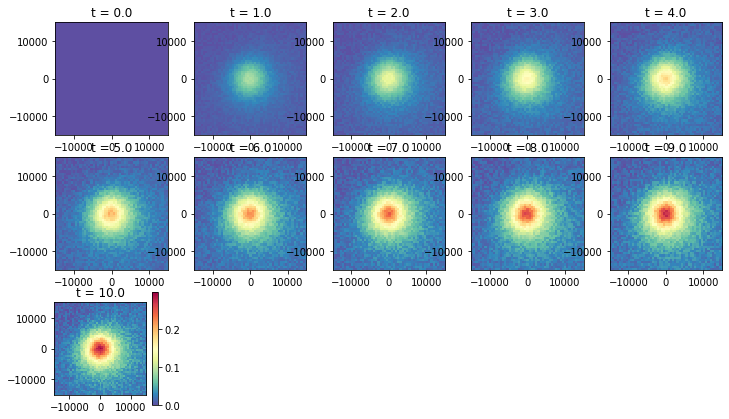

In [81]:
# allocate the measurements
LOS_disp = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])
Uncen = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])

# define the looking angle
theta_l = 45 * np.pi / 180
phi_l = 23 * np.pi / 180
lkag = [np.sin(phi_l)*np.cos(theta_l), np.sin(phi_l)*np.sin(theta_l), np.cos(phi_l)]

# calcualte the displacement
for i in np.arange(0, len(ti)):
    Um, Vm, Wm = vEnKF.yang_disp(X_InSAR, Y_InSAR, 0,
                                 xs=xs*1e3, ys=ys*1e3, zs=-zs*1e3, 
                                 a=r1s*1e3, b=r2s*1e3,
                                 lamda=lamda, mu=mu, nu=nu,
                                 P=OPi[i]*1e6,
                                 theta=thetas, phi=phis)
    
    disp = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]
    random_error = np.random.rand(X_InSAR.shape[0], X_InSAR.shape[1]) * disp.max() * 0.1
    Uncen[:, :, i] = random_error
    LOS_disp[:, :, i] = disp + random_error
    cmax = LOS_disp[:, :, i].max()

## reformat the dataset for EnKF
# convert measurement location to 1d array
x_InSAR = X_InSAR.reshape(-1)
y_InSAR = Y_InSAR.reshape(-1)
# convert measurement and error to 1d array
dat_InSAR = np.zeros([nobs, len(ti)])
err_InSAR = np.zeros([nobs, len(ti)])
# reformat
for i in np.arange(0, len(ti)):
    dat_InSAR[:, i] = LOS_disp[:,:,i].reshape(-1)
    err_InSAR[:, i] = Uncen[:,:,i].reshape(-1)
    
# plot synthetic InSAR data
plt.figure(2, figsize=(12,12))
for i in np.arange(0, len(ti)):
    plt.subplot(5,5,i+1)
    plt.imshow(LOS_disp[:,:,i],
              extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
              vmin=0, vmax=cmax,
              cmap=cm.Spectral_r)
    plt.title('t = {}'.format(ti[i]))
plt.colorbar()
plt.show()

### Generate synthetic GNSS data

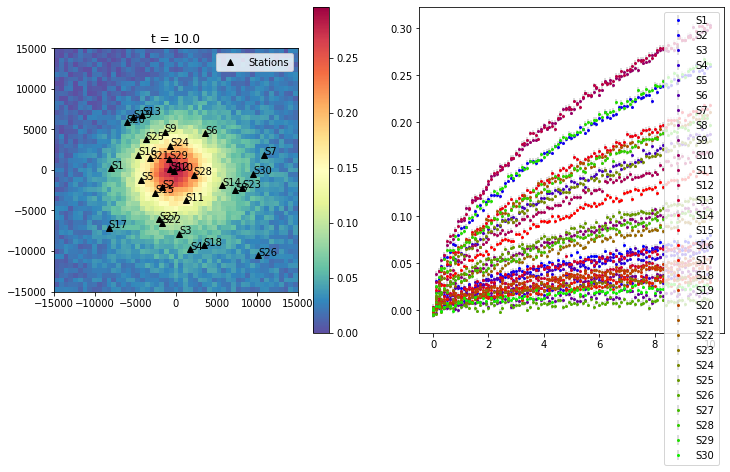

In [102]:
# number of stations
NStation = 30
# generate random location of GNSS stations
x_GNSS = np.random.standard_normal(NStation) * 5e3
y_GNSS = np.random.standard_normal(NStation) * 5e3

# plot location of the GNSS stations
plt.figure(6, figsize=(12,6))
plt.subplot(121)
plt.plot(x_GNSS, y_GNSS, 'k^', label='Stations')
for i in np.arange(0, NStation):
    plt.text(x_GNSS[i], y_GNSS[i], "S{}".format(i+1))
plt.imshow(LOS_disp[:,:,-1],
           extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
           vmin=0, vmax=cmax,
           cmap=cm.Spectral_r)
plt.title('t = {}'.format(ti[-1]))
plt.colorbar()
plt.legend()

# allocate the measurements
Gx = np.zeros([NStation, len(tg)])
Gy = np.zeros([NStation, len(tg)])
Gz = np.zeros([NStation, len(tg)])
# uncertainty of GNSS
sx0 = cmax * 1e-3 * 5
sy0 = sx0
sz0 = sx0 * 2
# Error data of GNSS
Sx = np.ones([NStation, len(tg)]) * sx0
Sy = np.ones([NStation, len(tg)]) * sy0
Sz = np.ones([NStation, len(tg)]) * sz0

# calcualte the displacement
for i in np.arange(0, len(tg)):
    Um, Vm, Wm = vEnKF.yang_disp(x_GNSS, y_GNSS, 0,
                                 xs=xs*1e3, ys=ys*1e3, zs=-zs*1e3, 
                                 a=r1s*1e3, b=r2s*1e3,
                                 lamda=lamda, mu=mu, nu=nu,
                                 P=OPg[i]*1e6,
                                 theta=thetas, phi=phis)
    
    Gx[:, i] = Um + np.random.standard_normal(NStation) * sx0
    Gy[:, i] = Vm + np.random.standard_normal(NStation) * sy0
    Gz[:, i] = Wm + np.random.standard_normal(NStation) * sz0
    
plt.subplot(122)
cmap = cm.get_cmap('brg')
for i in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[i, :],
                 yerr=Sz[i, :],
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(i/NStation),
                 markeredgecolor=cmap(i/NStation),
                 label='S{}'.format(i+1)
                )
plt.legend()    
plt.show()
    

## Combine InSAR and GNSS data

In [103]:
# uniform timeseries
tu = np.sort(np.unique(np.hstack([ti, tg])))

# allocate data dict
DATA = {"x": [],
        "y": [],
        "typ": [],
        "ddvx": [],
        "ddvy": [],
        "ddvz": [],
        "dat": [],
        "err": []
       }

# do for all time steps
for i in np.arange(0, len(tu)):
    LOCx = []
    LOCy = []
    Type = []
    DDVx = []
    DDVy = []
    DDVz = []
    data = []
    erro = []
    
    # if there is InSAR data
    if tu[i] in ti:
        # append location
        LOCx = np.hstack([LOCx, x_InSAR])
        LOCy = np.hstack([LOCy, y_InSAR])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(x_InSAR.shape)])
        # looking angle
        DDVx = np.hstack([DDVx, np.ones(x_InSAR.shape) * lkag[0]])
        DDVy = np.hstack([DDVy, np.ones(x_InSAR.shape) * lkag[1]])
        DDVz = np.hstack([DDVz, np.ones(x_InSAR.shape) * lkag[2]])
        # find InSAR data and error
        ii = np.where(ti == tu[i])[0][0]
        data = np.hstack([data, dat_InSAR[:, ii]])
        erro = np.hstack([erro, err_InSAR[:, ii]])
        
    # if there is GNSS data
    if tu[i] in tg:
        # append location
        LOCx = np.hstack([LOCx, x_GNSS, x_GNSS, x_GNSS])
        LOCy = np.hstack([LOCy, y_GNSS, y_GNSS, y_GNSS])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(len(x_GNSS) * 3) + 1])
        # looking angle (E=[1,0,0], N=[0,1,0], U=[0,0,1])
        DDVx = np.hstack([DDVx, np.ones(len(x_GNSS)), np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVy = np.hstack([DDVy, np.zeros(len(x_GNSS)), np.ones(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVz = np.hstack([DDVz, np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS)), np.ones(len(x_GNSS))])
        # find GNSS data and error
        ig = np.where(tg == tu[i])[0][0]
        data = np.hstack([data, Gx[:, ig]])
        data = np.hstack([data, Gy[:, ig]])
        data = np.hstack([data, Gz[:, ig]])
        erro = np.hstack([erro, Sx[:, ig]])
        erro = np.hstack([erro, Sy[:, ig]])
        erro = np.hstack([erro, Sz[:, ig]])

    # storing data
    DATA["x"].append(LOCx)
    DATA["y"].append(LOCy)   
    DATA["typ"].append(Type)
    DATA["ddvx"].append(DDVx)
    DATA["ddvy"].append(DDVy)
    DATA["ddvz"].append(DDVz)
    DATA["dat"].append(data)
    DATA["err"].append(erro)
    
    # print status
    print("t={}, x={}, typ={}, ddv={}, dat={}, err={}".format(tu[i],
                                                             len(LOCx),
                                                             len(Type),
                                                             len(DDVx),
                                                             len(data),
                                                             len(erro)))

t=0.0, x=2691, typ=2691, ddv=2691, dat=2691, err=2691
t=0.1, x=90, typ=90, ddv=90, dat=90, err=90
t=0.2, x=90, typ=90, ddv=90, dat=90, err=90
t=0.30000000000000004, x=90, typ=90, ddv=90, dat=90, err=90
t=0.4, x=90, typ=90, ddv=90, dat=90, err=90
t=0.5, x=90, typ=90, ddv=90, dat=90, err=90
t=0.6000000000000001, x=90, typ=90, ddv=90, dat=90, err=90
t=0.7000000000000001, x=90, typ=90, ddv=90, dat=90, err=90
t=0.8, x=90, typ=90, ddv=90, dat=90, err=90
t=0.9, x=90, typ=90, ddv=90, dat=90, err=90
t=1.0, x=2691, typ=2691, ddv=2691, dat=2691, err=2691
t=1.1, x=90, typ=90, ddv=90, dat=90, err=90
t=1.2000000000000002, x=90, typ=90, ddv=90, dat=90, err=90
t=1.3, x=90, typ=90, ddv=90, dat=90, err=90
t=1.4000000000000001, x=90, typ=90, ddv=90, dat=90, err=90
t=1.5, x=90, typ=90, ddv=90, dat=90, err=90
t=1.6, x=90, typ=90, ddv=90, dat=90, err=90
t=1.7000000000000002, x=90, typ=90, ddv=90, dat=90, err=90
t=1.8, x=90, typ=90, ddv=90, dat=90, err=90
t=1.9000000000000001, x=90, typ=90, ddv=90, dat=90, e

### Generate initial ensemble

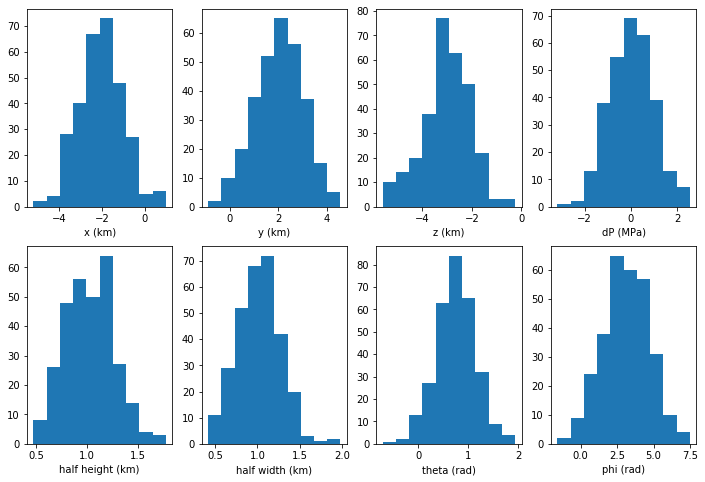

In [104]:
# number of ensemble
nens = 300
# number of iteration
nitr = 5

# number of the parameters
npar = 8
# Initial parameter guess
# point source location
# x (km)
xc0 = np.random.standard_normal(nens) * 1 + -2
# y (km)
yc0 = np.random.standard_normal(nens) * 1 + 2
# z (km)
zc0 = np.random.standard_normal(nens) * 1 - 3
# half height (km)
r10 = np.random.standard_normal(nens) * 0.25 + 1
# half width (km)
r20 = np.random.standard_normal(nens) * 0.25 + 1
# overpressure (MPa)
dp0 = np.random.standard_normal(nens) * 1 + 0
# theta
theta0 = np.random.standard_normal(nens) * np.pi/8 + np.pi/4
#phi
phi0 = np.random.standard_normal(nens) * np.pi/2 + np.pi

## Plot initial ensemble parameter
plt.figure(3,figsize=(12,8))
plt.subplot(241)
plt.hist(xc0)
plt.xlabel('x (km)')
plt.subplot(242)
plt.hist(yc0)
plt.xlabel('y (km)')
plt.subplot(243)
plt.hist(zc0)
plt.xlabel('z (km)')
plt.subplot(244)
plt.hist(dp0)
plt.xlabel('dP (MPa)')
plt.subplot(245)
plt.hist(r10)
plt.xlabel('half height (km)')
plt.subplot(246)
plt.hist(r20)
plt.xlabel('half width (km)')
plt.subplot(247)
plt.hist(theta0)
plt.xlabel('theta (rad)')
plt.subplot(248)
plt.hist(phi0)
plt.xlabel('phi (rad)')
plt.show()

# Use both InSAR and GNSS (Yang et al., 1988 model)

In [105]:
# allocate the A matrix
A = np.zeros([npar, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = r10
A[4, :] = r20
A[5, :] = dp0
A[6, :] = theta0
A[7, :] = phi0

# allocate the root mean square error
RMSE = np.zeros([len(tu), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(tu)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]

GNSS_res_avg = np.zeros([len(tg), NStation * 3])
GNSS_res_std = np.zeros([len(tg), NStation * 3])

# for all time steps
for step in np.arange(1, len(tu)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = DATA['dat'][step]
    Err = DATA['err'][step]
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        # allocate A matrix result part
        A_res = np.zeros([len(Dat), nens])
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            # calcualate displacement
            Um, Vm, Wm = vEnKF.yang_disp(DATA['x'][step], DATA['y'][step], 0,
                                         xs=A[0, i]*1e3, ys=A[1, i]*1e3,
                                         zs=-A[2, i]*1e3, 
                                         a=A[3, i]*1e3, b=A[4, i]*1e3,
                                         lamda=lamda, mu=mu, nu=nu,
                                         P=A[5, i]*1e6,
                                         theta=A[6, i], phi=A[7, i])
            

            # store the data into A matrix
            A_res[:, i] = Um * DATA['ddvx'][step] + Vm * DATA['ddvy'][step] + Wm * DATA['ddvz'][step]
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((A_res[:, i] - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        A = np.vstack([A[0:npar], A_res])
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    if tu[step] in tg:
        ig = np.where(tg == tu[step])[0][0]
        GNSS_res_avg[ig, :] = np.mean(A_res[DATA['typ'][step]==2, :], axis=1)
        GNSS_res_std[ig, :] = np.std(A_res[DATA['typ'][step]==2, :], axis=1)

print('All done')

step = 1
RMSE = 0.010795261319281107
RMSE = 0.009476456016406185
RMSE = 0.008813836325151437
RMSE = 0.00824344043569285
RMSE = 0.007713091432184182
step = 2
RMSE = 0.010068337645855054
RMSE = 0.009316845927419205
RMSE = 0.008620181211439724
RMSE = 0.007953417688229854
RMSE = 0.007335022896533794
step = 3
RMSE = 0.009529651681597397
RMSE = 0.008759612312848605
RMSE = 0.008096334552916798
RMSE = 0.00753183257115646
RMSE = 0.007054776017280429
step = 4
RMSE = 0.008313795097412152
RMSE = 0.007803318196675244
RMSE = 0.007364675704764239
RMSE = 0.006986668690824927
RMSE = 0.006659555498796726
step = 5
RMSE = 0.00888751987329766
RMSE = 0.008500558021923135
RMSE = 0.008155324142279078
RMSE = 0.007844317125035891
RMSE = 0.007558097919690892
step = 6
RMSE = 0.00906140426229831
RMSE = 0.008684197741951134
RMSE = 0.008256679527124599
RMSE = 0.007764500720932364
RMSE = 0.0072581588661457495
step = 7
RMSE = 0.008575722153741949
RMSE = 0.008082404628888708
RMSE = 0.007709063365864827
RMSE = 0.0074297

RMSE = 0.020356616608400654
RMSE = 0.0202752375264602
RMSE = 0.02019529480647017
RMSE = 0.020116568046642018
step = 57
RMSE = 0.020460979895721484
RMSE = 0.020382844534711602
RMSE = 0.020306096969674784
RMSE = 0.02023046309190762
RMSE = 0.02015583285183016
step = 58
RMSE = 0.020945732997828877
RMSE = 0.020870001139084247
RMSE = 0.020793769810846113
RMSE = 0.020717989151039427
RMSE = 0.020642975220978403
step = 59
RMSE = 0.020845594774604043
RMSE = 0.020765950687353398
RMSE = 0.02107244569208386
RMSE = 0.020662795886201513
RMSE = 0.020589079911771915
step = 60
RMSE = 0.019318714737754577
RMSE = 0.019307964202942614
RMSE = 0.01929730018613495
RMSE = 0.019286719780566515
RMSE = 0.019276220220952423
step = 61
RMSE = 0.021505745913724467
RMSE = 0.021426371263755767
RMSE = 0.02135030467834683
RMSE = 0.021275881085717045
RMSE = 0.02120266543047333
step = 62
RMSE = 0.022347947130268553
RMSE = 0.022273111804986832
RMSE = 0.022200650575721566
RMSE = 0.02212954598712568
RMSE = 0.02205943174373464

### RMSE (InSAR + GNSS; Yang et al., 1988)

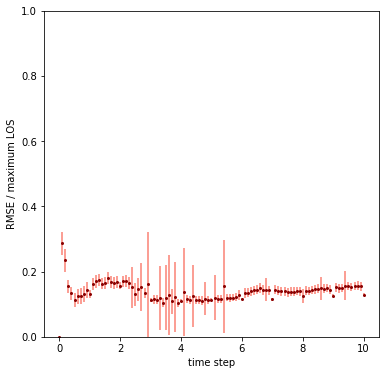

In [86]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=tu, y=np.mean(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.ylim([0,1])
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.show()

### Location of the spheroid's center  (InSAR + GNSS; Yang et al., 1988)

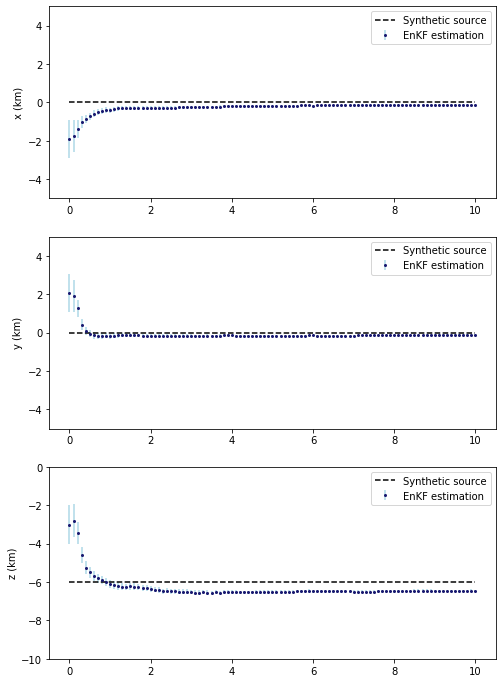

In [87]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                 np.ones(ti.shape) * r1s,
                 np.ones(ti.shape) * r2s,
                 OPi,
                 np.ones(ti.shape) * thetas,
                 np.ones(ti.shape) * phis,]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
plt.show()

### Half Height and Half Width, and Overpressure  (InSAR + GNSS; Yang et al., 1988)

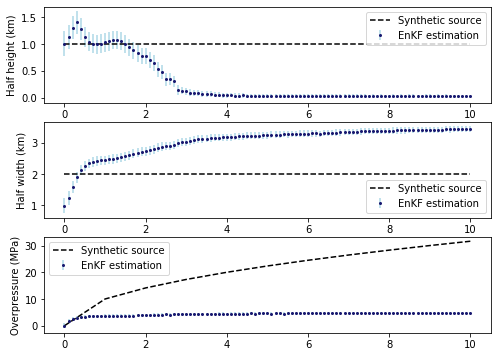

In [88]:
plt.figure(5, figsize=(8,6))
y_label = ['Half height (km)', 'Half width (km)', 'Overpressure (MPa)']
for par in np.arange(3, 6):
    # plot parameter estimation
    plt.subplot(3,1,par-2)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
    
plt.show()

### Dip angle and direction  (InSAR + GNSS; Yang et al., 1988)

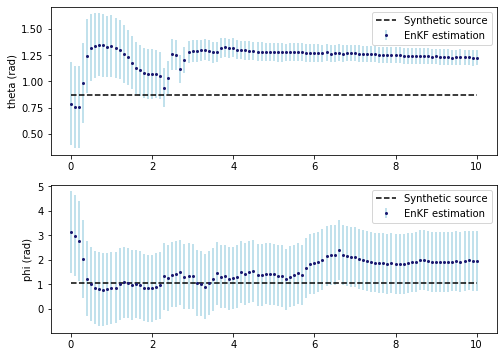

In [89]:
plt.figure(6, figsize=(8,6))
y_label = ['theta (rad)', 'phi (rad)']
for par in np.arange(6, 8):
    # plot parameter estimation
    plt.subplot(2,1,par-5)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-6])
    plt.legend()
    
plt.show()

### Volume change (InSAR + GNSS; Yang et al., 1988 model)

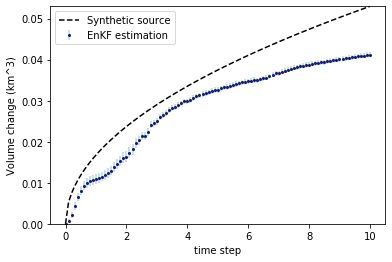

In [93]:
## calculate the volume change of models
r1m = param_est[3, :, :]
r2m = param_est[4, :, :]
dPm = param_est[5, :, :]
K = E / 3 / (1 - 2 * nu)
dVm = r2m * r2m * r2m * dPm * 1e6 * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = r2s * r2s * r2s * OPg * 1e6 * 4 * np.pi / 3 / K

# plot
plt.plot(tg, dVs, 'k--', label='Synthetic source')
plt.errorbar(x=tg, y=np.mean(dVm, axis=0),
             yerr=np.std(dVm, axis=0),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation')
            
plt.ylim([0, dVs.max()])
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.show()

### GNSS results  (InSAR + GNSS; Yang et al., 1988)

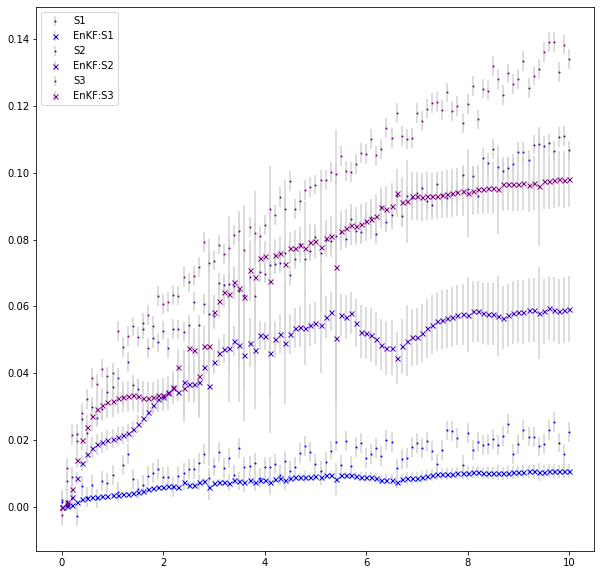

In [94]:
plt.figure(10, figsize=(10,10))
for istation in np.arange(0, NStation-5):
    plt.errorbar(x=tg, 
                 y=Gz[istation, :],
                 yerr=Sz[istation, :],
                 marker='o', markersize=1,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='S{}'.format(istation+1)
                )

    plt.errorbar(x=tg, 
                 y=GNSS_res_avg[:, istation + NStation * 2],
                 yerr=GNSS_res_std[:, istation + NStation * 2],
                 marker='x', markersize=5,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='EnKF:S{}'.format(istation+1)
                )

plt.legend()    
plt.show()

### InSAR results (InSAR + GNSS; Yang et al., 1988) last step

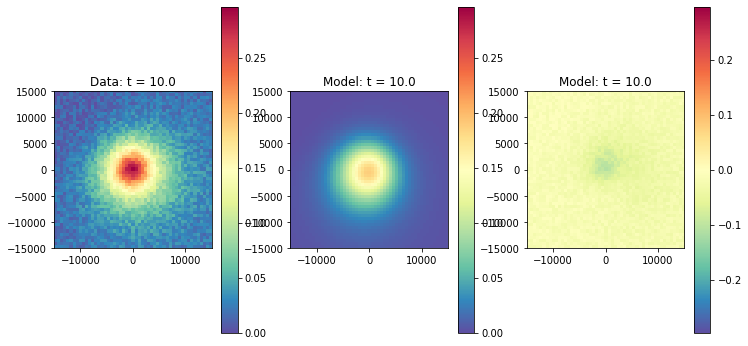

In [95]:
# select step
step = -1

# calculate the last step of the model
Um, Vm, Wm = vEnKF.yang_disp(X_InSAR, Y_InSAR, 0,
                             xs=np.mean(param_est[0, :, step])*1e3, 
                             ys=np.mean(param_est[1, :, step])*1e3,
                             zs=-np.mean(param_est[2, :, step])*1e3,
                             a=np.mean(param_est[3, :, step])*1e3,
                             b=np.mean(param_est[4, :, step])*1e3,
                             lamda=lamda, mu=mu, nu=nu,
                             P=np.mean(param_est[5, :, step])*1e6,
                             theta=np.mean(param_est[6, :, step]),
                             phi=np.mean(param_est[7, :, step])
                            )

# calculate the LOS displacement
LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]

# Plot data
plt.figure(6, figsize=(12,6))
plt.subplot(131)
plt.imshow(LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Data: t = {}'.format(ti[step]))

# Plot model
plt.subplot(132)
plt.imshow(LOS_model,
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))

# Plot misfit
plt.subplot(133)
plt.imshow(LOS_model - LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=-cmax, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))
plt.show()